In [1]:
# Downloading training data

import urllib
from pathlib import Path
from zipfile import ZipFile


URL = 'https://nnfs.io/datasets/fashion_mnist_images.zip'
FILE = 'fashion_mnist_images.zip'
FOLDER = 'fashion_mnist_images'

if not Path(FILE).is_file():
    print(f'Downloading {URL} and saving as {FILE}...')
    urllib.request.urlretrieve(URL, FILE)
    
    print(f'Unzipping images to ./{FOLDER}...')
    with ZipFile(FILE) as zf:
        zf.extractall(FOLDER)
    
    print('Done!')


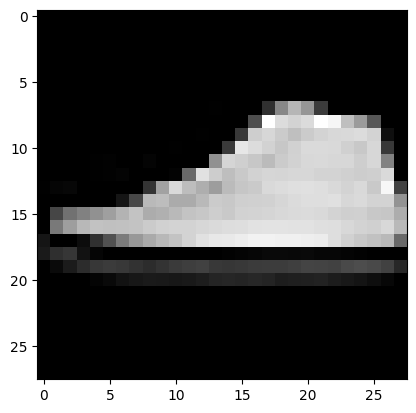

In [2]:
# Show an image from dataset

import cv2
import matplotlib.pyplot as plt

image_data = cv2.imread('fashion_mnist_images/train/7/0002.png', cv2.IMREAD_UNCHANGED)
plt.imshow(image_data, cmap='gray')
plt.show()

In [22]:
# Fill in X and y for training

import numpy as np


def load_mnist_dataset(path):
    labels = Path(FOLDER) / path

    X = []
    y = []
    for label in labels.iterdir():
        for file in label.iterdir():
            image = cv2.imread(str(file), cv2.IMREAD_UNCHANGED)
            X.append(image)
            y.append(label.name)
    
    return np.array(X), np.array(y).astype(np.uint8)


print('Loading up the training dataset...')
X, y = load_mnist_dataset('train')

print('Loading up the testing dataset...')
X_test, y_test = load_mnist_dataset('test')

print('Done!')

Loading up the training dataset...
Loading up the testing dataset...
Done!


In [24]:
# Scale the pixel values from (0 to 255) to (-1 to 1)

X = (X.astype(np.float32) - 127.5) / 127.5
X_test = (X_test.astype(np.float32) - 127.5) / 127.5

print(X.min(), X.max())
print(X.shape)

-1.0 1.0
(60000, 28, 28)


In [26]:
# Flatten images

X = X.reshape(X.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print(X.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [30]:
# Shuffle the X and y

keys = np.array(range(X.shape[0]))
np.random.shuffle(keys)

X = X[keys]
y = y[keys]

print(y[:10])

[5 0 6 0 4 4 6 3 6 6]


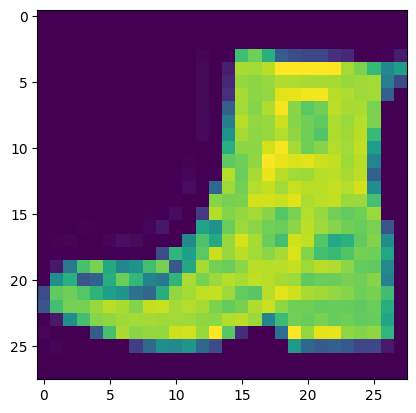

9


In [31]:
# Check whether the shuffling was applied correctly

plt.imshow(X[1337].reshape(28, 28))
plt.show()

print(y[1337])

# (Check manually)